# General Regression, Splines, CV and Regularization

In this worksheet, we will develop different approaches for linear regression. 

First, let's generate some data from the exponential regression model:
$$y_i = f(x_i) \times  \exp(\varepsilon) = 2 \exp( .5 x ) \times \exp( \varepsilon )$$

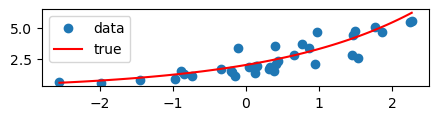

In [1]:
import numpy as np; import matplotlib.pyplot as plt; np.random.seed(0); plt.figure(figsize=(5, 1))

N = 35; x = np.random.normal(0, 1, N) # generate x values
y = 2 * np.exp( x / 2 ) * np.random.lognormal( 0, .3, N) # generate y values 

plt.plot(x, y, 'o', label='data') # plot simulated data

x_span = np.linspace(x.min(), x.max(), 100)  # create x-values for plotting function 
y_span_fun = 2 * np.exp( x_span / 2 )    # calculate function evaluations 
plt.plot(x_span, y_span_fun , color = 'r', label='true'); plt.legend()

## 1. Parametric Nonlinear Regression 

First, we fit a parametric exponential model to the data. Note that this requires a-priori knowledge of the form (exponential) of the function, which is rarely justified in practice. We will use the `curve_fit()` function from the `SciPy` library; this funciton fitting general curves to data using **least squares**.

In [2]:
from scipy.optimize import curve_fit

# Define the nonlinear function
def my_exp_fun(x, a, b):
    return a * np.exp(b * x) 

popt, pcov = curve_fit(my_exp_fun, x, y)

print(popt) # show optimal parameter values 

[1.90398064 0.48274527]


Plot the data and the fitted parametric nonlinear curve.

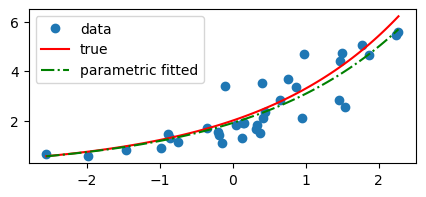

In [3]:
import numpy as np; import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.plot(x, y, 'o', label='data') # plot simulated data

x_span = np.linspace(x.min(), x.max(), 100)  # create x-values for plotting function 
y_span_fun = 2 * np.exp( x_span / 2 )      # calculate function evaluations 
y_pred = my_exp_fun(x_span, popt[0], popt[1])

plt.plot(x_span, y_span_fun, color = 'r', label='true')
plt.plot(x_span, y_pred, '-.', color = 'g', label='parametric fitted')
plt.legend()

## 2. Polynomial (10th order)

### 2.1. Polynomial Bases

Assume we did not know that the function we try to fit is exponential, but we know that it is *smooth* (continuous & differentiable) and can be approximated by a polynomial. Functions that can be represented by a power series (a.k.a. Taylor series) are called [entire](https://en.wikipedia.org/wiki/Entire_function); the exponential is such a function.
Let's approximate the regression function by a 10th order polynomial:
$$ f(x) = \sum_{j=0}^{10} w_j x^j$$ 

#### 2.1.1. Linear Regression ( scikit-learn,  polynomial features )

Below is code that fits and plots this model using `scikit-learn`:

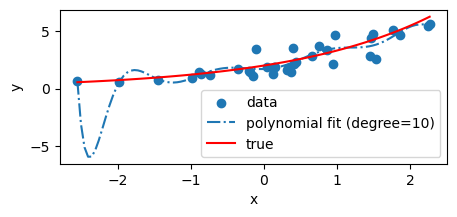

In [4]:
import numpy as np; from sklearn.preprocessing import PolynomialFeatures; from sklearn.linear_model import LinearRegression 
from sklearn.pipeline import make_pipeline; import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))

# Create polynomial features
polynomial_features = PolynomialFeatures(degree=10)
linear_regression = LinearRegression()
pipeline = make_pipeline(polynomial_features, linear_regression)

# Fit the model
pipeline.fit(x.reshape(-1,1), y)

# Predict using the model
y_polyfit = pipeline.predict(x_span.reshape(-1,1))

# Plot the results
plt.scatter(x, y, label='data'); plt.plot(x_span, y_polyfit, '-.', label='polynomial fit (degree=10)')
plt.plot( x_span, y_span_fun, 'r', label='true');plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.show()

In [5]:
print("Intercept:",linear_regression.intercept_,"\n")
print("Coeffecients:",linear_regression.coef_,"\n")

Intercept: 1.6996609756192225 

Coeffecients: [ 0.          0.22201483  2.73947466  2.4791866  -3.96112446 -1.80161269
  2.13411646  0.45223324 -0.45438144 -0.03516763  0.0325217 ] 



#### 2.1.2. Linear Regression (design matrix, polynomial features)

Replicate this model fit by creating the polynomial features and design matrix ($N\times 11$) and solving the OLS for the weights. 
Plot the resulting fited model together with the data and true model, as well as the polynomial bases functions used (in log-scale). 
The started code below uses `scikit-learns`'s `PolynomialFeatures` function to build the features.

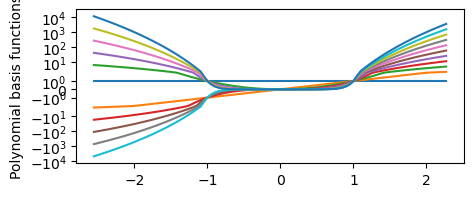

In [6]:
import numpy as np; from sklearn.preprocessing import PolynomialFeatures; from sklearn.linear_model import LinearRegression 
from sklearn.pipeline import make_pipeline; import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))

poly = PolynomialFeatures(10)
Xpoly = poly.fit_transform(x.reshape(-1,1))

### your code here 
wpoly = np.linalg.inv( Xpoly.T @ Xpoly) @ ( Xpoly.T @ y ) 

Xpolyspan = poly.fit_transform(x_span.reshape(-1,1))
y_polyfit2 = Xpolyspan @ wpoly

plt.plot( x_span, Xpolyspan );plt.yscale('symlog');plt.ylabel("Polynomial basis functions");

In [7]:
print("w:",wpoly,"\n") #wpoly = np.linalg.inv( Xpoly.T @ Xpoly ) @ ( Xpoly.T @ y ) 

w: [ 1.69966098  0.22201483  2.73947466  2.4791866  -3.96112447 -1.80161269
  2.13411646  0.45223324 -0.45438144 -0.03516763  0.0325217 ] 



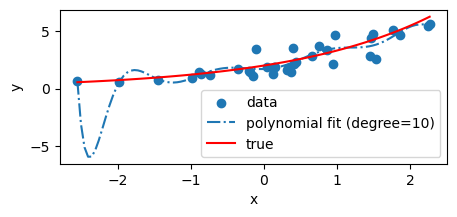

In [8]:
import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.scatter(x, y, label='data');plt.plot(x_span, y_polyfit2, '-.', label='polynomial fit (degree=10)')
plt.plot( x_span, y_span_fun, 'r', label='true');plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.show()

### 2.2. Spline bases  (no intrenal knots, design matrix)

The following code calculates the spline bases for a 10th degree polynomial (**with no intrenal knots**) and fits the OLS curve to the data. 
It then plots the fit vs the data and the bases functions (in log-scale).

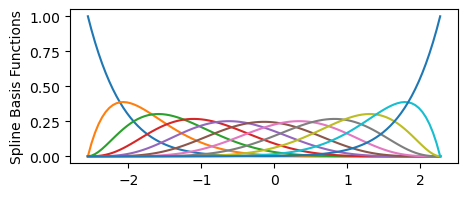

In [9]:
from scipy.interpolate import BSpline; import numpy as np;

k=10 # degree 
t = np.concatenate( [ np.repeat(x.min(),k+1), np.repeat(x.max(),k+1) ] )  # Knot vector
spl = BSpline(t, np.ones( [len(t)-k-1,1]), k)  # Create the B-spline object

Xspl = spl.design_matrix(x, spl.t, k).toarray()
wspl = np.linalg.inv( Xspl.T @ Xspl ) @ ( Xspl.T @ y ) 

Xsplspan = spl.design_matrix(x_span, spl.t, k).toarray()
y_polyfit3 = Xsplspan @ wspl

import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.plot(x_span, Xsplspan );plt.ylabel("Spline Basis Functions");

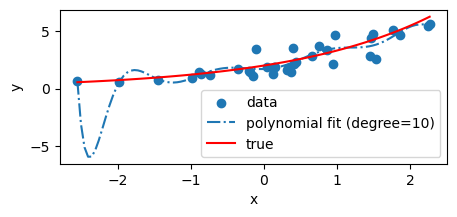

In [10]:
import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.scatter(x, y, label='data'); plt.plot(x_span, y_polyfit3, '-.', label='polynomial fit (degree=10)')
plt.plot( x_span, y_span_fun, 'r', label='true');plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.show()

## 2.3. Comparison (polyBases&SplineBases)
The plots demonstrate that the spline fit is identical to the polynomial regression fit, but the bases functions used are very **different**:

    Polynomial bases: are unbounded and can take very large values, which can cause numerical instability problems; 
    Spline bases: are bounded. 

Moreover, both bases are correlated, but polynomial bases are even more so, especially for odd & odd, even & even powers (see correlation sub-matrices use `np.corrcoef()`; the maximum correlation for polynomial bases functions is 99%, vs 83% for spline bases).

In [11]:
# Correlation matrices for the last 5 bases functions
print("PolyBases:\n", np.round( np.corrcoef( Xpoly.T[5:10,:] ) , 2) ,"\n")
print("SplineBases:\n", np.round( np.corrcoef( Xspl.T[5:10,:] ) , 2),"\n")

PolyBases:
 [[ 1.   -0.34  0.99 -0.44  0.96]
 [-0.34  1.   -0.44  0.99 -0.52]
 [ 0.99 -0.44  1.   -0.54  0.99]
 [-0.44  0.99 -0.54  1.   -0.62]
 [ 0.96 -0.52  0.99 -0.62  1.  ]] 

SplineBases:
 [[ 1.    0.83  0.33 -0.34 -0.62]
 [ 0.83  1.    0.78  0.11 -0.37]
 [ 0.33  0.78  1.    0.67  0.15]
 [-0.34  0.11  0.67  1.    0.8 ]
 [-0.62 -0.37  0.15  0.8   1.  ]] 



## 3. Piecewise Polynomials and Splines (cubic spline bases & equidistant knots)

Instead of modelling the regression function as a high-order polynomial/power series, we can model it as a **low-order piecewise polynomial**. 
A common choice is to use a **piecewise cubic** function, where each piece is a 3rd degree polynomial, and there are additional continuity and smoothness constraints at the junction points of the curve.

Cubic splines are flexible enough to approximate a wide range of smooth functions, and the spline bases representation avoids any numerical challenges.
The reason for the good numerical performance is that (piecewise polynomial) spline bases are bounded and **localized**, i.e., they don't overlap as much. 

As an example, let's approximate the exponential regression function with a **cubic spline bases** with **10 equidistant knots** over the range of the data, (i.e., there are 10 (=8+2) cubic polynomial segments and 12 (= 8+3+1) bases functions, plotted below). 

In [12]:
from scipy.interpolate import BSpline,make_lsq_spline; import numpy as np;

# 1. Set Up Knots Parameters
k = 3 # degree of polynomial 
n_knots = 10  # number (8) of internal knots + 2 end knots

# 2. Create the Knot Vector
i_knots = np.linspace( x.min(), x.max(), n_knots ) ## Create internal knots 
knots =  np.r_[ (x.min(),)*k, i_knots, (x.max(),)*k ]

# 3. Prepare the Data and Fit the Spline
y = y[np.argsort(x)]; x.sort()  # make_lsq_spline requires sorted data
cspl = make_lsq_spline(x, y, knots, k) # creates least-squares B-spline fit of data given knots, degree.
y_span_fitted = cspl(x_span) # fitted y-values. value of cubic spline at every point in x_span.

# 4. Extract Basis Functions
Xcsplspan = cspl.design_matrix(x_span, cspl.t, k).toarray()

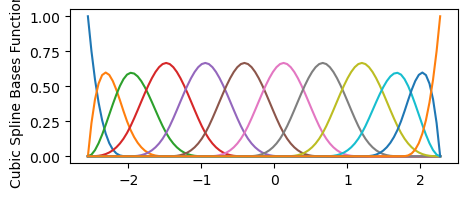

In [13]:
# Plot the Basis Functions
import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.plot(x_span, Xcsplspan ); plt.ylabel("Cubic Spline Bases Functions");

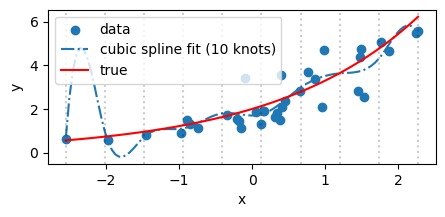

In [14]:
import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))

# 1. Plot data and models
plt.scatter(x, y, label='data')
plt.plot(x_span,y_span_fitted, '-.', label='cubic spline fit (10 knots)')
plt.plot( x_span, y_span_fun, 'r', label='true'  )

# 2. Knot lines
for i in range(n_knots): ## draw verticle dash line at knots
    plt.axvline(x = i_knots[i], color = 'k', linestyle = ":" , alpha = .2) 
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.show()

### 3.2. Replicated (by design matrix)
Replicate the model fit from first principles: find the **cubic spline bases coefficients** with **least squares**, and use them to calculate and plot the model fit, together with the data.

$$y_*=X_*\hat{w}=X_*(X^TX)^{-1}X^Ty$$
oftenly, * means span

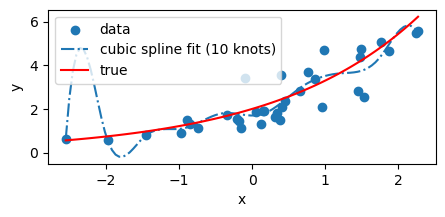

In [15]:
Xcspl = cspl.design_matrix(x, cspl.t, k).toarray()
Xcsplspan = cspl.design_matrix(x_span, cspl.t, k).toarray()

### your code here
wcspl = np.linalg.inv( Xcspl.T @ Xcspl ) @ ( Xcspl.T @ y ) 
y_csplfit = Xcsplspan @ wcspl

import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.scatter(x, y, label='data'); plt.plot(x_span, y_csplfit, '-.', label='cubic spline fit (10 knots)')
plt.plot( x_span, y_span_fun, 'r', label='true');plt.xlabel('x'); plt.ylabel('y'); plt.legend();plt.show()

## 4. Smoothing Splines ( ridge, L2 )

For the above example, we used the **number of internal knots** to control the **smoothness** of the fitted function. 
Another approach to **regularization** would be to use many bases functions and **shrink** the coefficients with ridge regression, a.k.a. *Smoothing Splines*.
The following code uses `scikit-learn` to fit such a model with smoothing penalty parameter $\lambda = 0.1$.

- `fit_intercept=False` : no need to learn an intercept separately because the spline basis handles that.

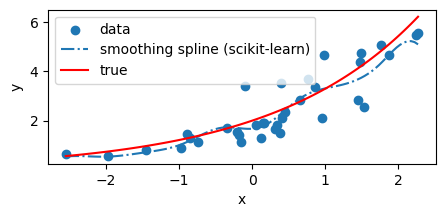

In [16]:
# Use Sklearn
from sklearn.linear_model import Ridge; from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

# 1. Create the Model
model = make_pipeline(
    SplineTransformer(n_knots=10, degree=3),
    Ridge(alpha=0.1, fit_intercept=False)
)

# 2. Model Fit
## Transforms x into spline basis features; Fits a regularized linear model to approximate y
model.fit(x.reshape(-1, 1),y)

# 3. Make Predictions
X_plot = x_span.reshape(-1, 1)
y_plot = model.predict(X_plot)

import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.scatter(x, y, label='data'); plt.plot(X_plot, y_plot, '-.', label="smoothing spline (scikit-learn)")
plt.plot( x_span, y_span_fun, 'r', label='true') ;plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.show()

### 4.1. Replicated (by design matrix)
Fit the smoothing spline from scratch using the splines bases design matrix (`Xcspl`). 
Recall that the parameter estimates for ridge regression are given by:
$$\mathbf{w} = ( \mathbf{X}^\top \mathbf{X} + \lambda \mathbf{I})^{-1} \mathbf{X}\mathbf{y}$$
Calculate the parameters and plot the smoothing spline fit on the same plot like the one above. 

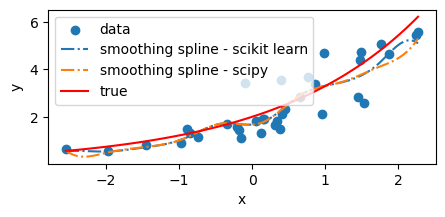

In [17]:
from scipy.interpolate import make_lsq_spline ### Use Scipy & Design Matrix 

LAMBDA = 0.1

y = y[np.argsort(x)]; x.sort()  # make_lsq_spline requires sorted data
cspl = make_lsq_spline(x, y, knots, k) # Fit the Spline
 
Xcspl = cspl.design_matrix(x, cspl.t, k).toarray() 
Xcsplspan = cspl.design_matrix(x_span, cspl.t, k).toarray()

wsspl = np.linalg.inv( Xcspl.T @ Xcspl + LAMBDA * np.eye(Xcspl.shape[1] )) @ ( Xcspl.T @ y) 
y_ssplfit = Xcsplspan @ wsspl

import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.scatter(x, y, label='data'); plt.plot(X_plot, y_plot, '-.', label="smoothing spline - scikit learn")
plt.plot(x_span, y_ssplfit, '-.', label='smoothing spline - scipy');plt.plot( x_span, y_span_fun, 'r', label='true'  )
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.show()

(Note that your ridge regression fit will not be identical to `scikit-learn`'s fit becuase the latter uses slightly different spline bases at the boundaries.)

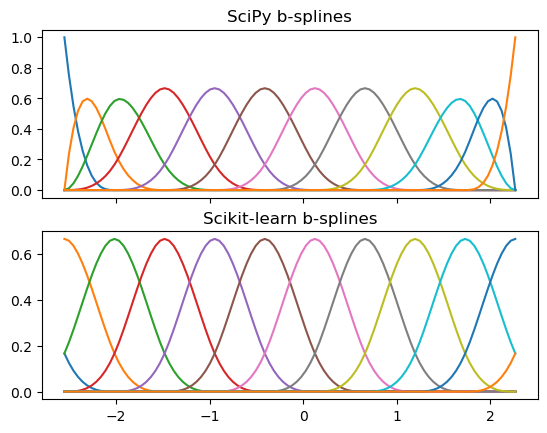

In [18]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(x_span, Xcsplspan); ax1.set_title("SciPy b-splines");

skl_spl = SplineTransformer(n_knots=10, degree=3 )
Xskl_spl = skl_spl.fit_transform(x_span.reshape(-1,1)) #sklearn design matrix 
ax2.plot(x_span, Xskl_spl); ax2.set_title("Scikit-learn b-splines");
for ax in fig.get_axes(): ax.label_outer()

## 4. Lasso (L1)

A common alternative to ridge regression ($L^2$ regularization) is the *Lasso* ($L^1$ regularization), which shrinks the coefficients *AND* does **variable selection**. The Lasso, or variable selection in general, is **not** use on regression splines because the bases functions work togehter to represent a piecewise polynomial. 

The Lasso/variable selection are commonly used when you have a lot of features and you try to sort out which ones are actually useful/relevant, especially if you expect the actual data generating mechanism/model to be sparse, i.e., to only rely on a few variables.

Nevertheless, and for the sake of example, we apply Lasso regularization to our splines regression; this requires just a small adjustment to our `scikit-learn` pipeline. For penalty parameter $\lambda = 0.03$ we get the fit below, which is almost flat for negative values. That's because the spline bases to the left got small or 0 coefficients whereas the bases to the right, where the exponential function picks up, where not shrunk as much in order to preserve a good fit. Once again, this is not the typical application of Lasso, but it illustrates the type of solutions you would get.

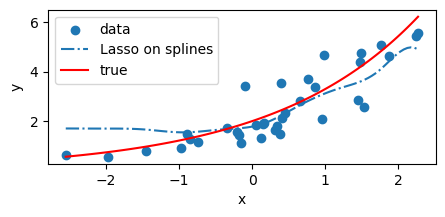

In [19]:
from sklearn.linear_model import Lasso; from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

# 1. Create the Model
model = make_pipeline( 
    SplineTransformer(n_knots=10, degree=3), 
    Lasso(alpha=.03)
)

# 2. Model Fit
model.fit(x.reshape(-1, 1),y)

# 3. Make Predictions
X_plot = x_span.reshape(-1, 1)
y_plot = model.predict(X_plot)

import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.scatter(x, y, label='data'); plt.plot(X_plot, y_plot, '-.', label="Lasso on splines")
plt.plot( x_span, y_span_fun, 'r', label='true');plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.show()

## 5. Cross-validation and Bias-Variance Tradeoff 

The main question in regularization is how to choose the appropriate amount of smoothing. For certain models and assumptions, there are theoretical results that tell us what the smoothing penalty should be. But more generally, we rely on the data to decide the right ammount of smoothing, using either a *validation set* or *cross-validation* (if we don't have enough data).

The code below fits multiple linear regression with **Leave-One-Out Cross-Validation (LOOCV)**, the default choice in `scikit-learn` which is efficient for **small** data sets (for larger data sets we would use *k-fold* cross validation, for $k \ll N$).

The optimal smoothing parameter with LOOCV was: 0.043159


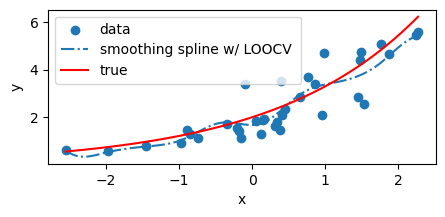

In [20]:
from sklearn.linear_model import RidgeCV
lambdas = np.exp( np.linspace( -6, -1, 50 ) )

# 1. Ridge regression with leave-one-out CV (LOOCV) for selecting λ
model = RidgeCV( alphas = lambdas, fit_intercept = False ) 
Xcspl = cspl.design_matrix(x, cspl.t, k).toarray()
Xcsplspan = cspl.design_matrix(x_span, cspl.t, k).toarray()

# 2. perform LOOCV on spline bases 
rcv = model.fit( Xcspl, y )  
print( "The optimal smoothing parameter with LOOCV was:", np.round( rcv.alpha_, 6 ) )

# 3. fitted values
y_plot = rcv.predict(Xcsplspan) 

import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.scatter(x, y, label='data'); plt.plot(X_plot, y_plot, '-.', label="smoothing spline w/ LOOCV ")
plt.plot( x_span, y_span_fun, 'r', label='true'); plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.show()

To verify how good the calue of the LOOCV parameter is, we will run a smiluation experiment: we will generate *new* data from the true model, and we will use them to **estimate the expected prediction error (EPE)** for different possible values of the smoothing parameter.

The optimal value for λ based on the out-of-sample performance simulation was  0.071887


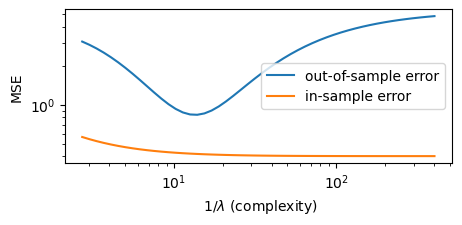

In [21]:
Nsim = 5000; 
xsim = np.random.normal(0, 1, Nsim) # generate x values
Xsim = cspl.design_matrix(xsim, cspl.t, k, extrapolate=True).toarray()
ysim = 2 * np.exp( xsim / 2 ) * np.random.lognormal( 0, .3, xsim.shape) # generate y values 
out_of_sample_MSE = np.zeros(lambdas.shape) 
in_sample_MSE = np.zeros(lambdas.shape) 

for i in range(lambdas.shape[0]):
    tmp = Ridge( alpha = lambdas[i], fit_intercept = False ).fit( Xcspl, y )
    out_of_sample_MSE[i] = np.mean( (ysim - tmp.predict( Xsim ))**2 )
    in_sample_MSE[i] = np.mean( (y - tmp.predict( Xcspl ))**2 )


import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.plot( 1/lambdas, out_of_sample_MSE, label = "out-of-sample error")
plt.plot( 1/lambdas, in_sample_MSE, label = "in-sample error"); plt.yscale("log"); plt.xscale("log")
plt.xlabel(r" $1/\lambda$ (complexity)"); plt.ylabel("MSE"); plt.legend();

print( "The optimal value for λ based on the out-of-sample performance simulation was ", 
      np.round( lambdas[ np.argmin(out_of_sample_MSE) ] , 6 ) ) 

In [22]:
lambdas[np.argmin(out_of_sample_MSE)]

0.07188748711185017

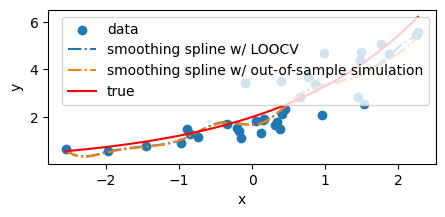

In [23]:
from sklearn.linear_model import RidgeCV

# Set Up the Range for Lambda 
lambdas = np.exp( np.linspace( -6, -1, 50 ) )

# Plot 1: RidgeCV with LOOCV
model = RidgeCV( alphas = lambdas, fit_intercept = False)
Xcspl = cspl.design_matrix(x, cspl.t, k).toarray()
rcv = model.fit( Xcspl, y ) 
Xcsplspan = cspl.design_matrix(x_span, cspl.t, k).toarray()
y_plot1 = rcv.predict(Xcsplspan) # fitted values

# Plot 2: Out of Sample
y_plot2 = Ridge(alpha = lambdas[np.argmin(out_of_sample_MSE)], fit_intercept = False ).fit( Xcspl, y ).predict(Xcsplspan)

import matplotlib.pyplot as plt; plt.figure(figsize=(5, 2))
plt.scatter(x, y, label='data'); plt.plot(X_plot,y_plot1, '-.', label="smoothing spline w/ LOOCV ")
plt.plot(X_plot, y_plot2, '-.', label="smoothing spline w/ out-of-sample simulation")
plt.plot( x_span, y_span_fun, 'r', label='true');plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.show()

In this case, LOOCV gave a smoothing penalty (λ) value that was very close to the optimal from simulating the model's out-of-sample performance. 
$\blacksquare$